# DSA210 Project – Apple vs Samsung Stock Analysis (2019–2024)

This notebook analyzes how the COVID-19 pandemic influenced the stock price behavior 
of two major technology companies: **Apple** and **Samsung**. By combining daily stock prices 
with global daily COVID-19 case counts, this study investigates whether external global shocks 
can affect investor behavior, market volatility, and company growth patterns.

This submission corresponds to the **28 November milestone**, which includes:
- Data collection  
- Data cleaning and preprocessing  
- Exploratory data analysis (EDA)  
- Statistical hypothesis testing  


## Research Questions

- How did Apple and Samsung stock prices change between 2019 and 2024?
- Did both companies show similar growth patterns before and after the COVID-19 pandemic?
- Is there a relationship between daily COVID-19 cases and the stock prices of Apple and Samsung?
- How can the average prices and returns of Apple and Samsung be compared over time?
- Which company adapted more quickly to the market changes caused by the pandemic?

## Hypotheses

- **H1:** In the early pandemic months, Apple's stock price increased faster than Samsung's.
- **H2:** Samsung reacts more slowly to market shocks, lagging behind Apple's price growth.
- **H3:** Global COVID-19 daily case counts are positively correlated with Apple’s stock price.
- **H4:** After 2021, Samsung exhibits higher volatility compared to Apple.
- **H5:** Apple outperforms Samsung in terms of monthly average returns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

plt.rcParams["figure.figsize"] = (12, 4)
sns.set(style="whitegrid")

## 1. Data Collection

In this section, Apple, Samsung, and COVID-19 datasets are loaded and merged into a single
dataframe using the `Date` column.


In [2]:
# Load CSV datasets (paths for this environment)
apple = pd.read_csv("/mnt/data/apple.csv")
samsung = pd.read_csv("/mnt/data/samsung.csv")
covid = pd.read_csv("/mnt/data/corona.csv")

# Automatically detect Samsung price column
possible_price_cols = ["Close", "Price", "Adj Close", "Adj_Close", "Closing Price"]
samsung_price_col = None

for col in possible_price_cols:
    if col in samsung.columns:
        samsung_price_col = col
        break

print("Samsung price column found:", samsung_price_col)

Samsung price column found: Price


In [3]:
# Fix date formats (robust)
apple["Date"] = pd.to_datetime(apple["Date"], dayfirst=True, errors="coerce")
samsung["Date"] = pd.to_datetime(samsung["Date"], dayfirst=True, errors="coerce")
covid["Date"] = pd.to_datetime(covid["Date"], dayfirst=True, errors="coerce")

# Merge datasets
df = apple.merge(samsung, on="Date", how="inner")
df = df.merge(covid, on="Date", how="left")

# Rename columns consistently
df = df.rename(columns={
    "Close": "Apple_Price",
    samsung_price_col: "Samsung_Price",
    "New cases": "Covid_Cases"
})

df.head()

/tmp/ipykernel_505/2883729984.py:3: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  samsung["Date"] = pd.to_datetime(samsung["Date"], dayfirst=True, errors="coerce")


,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Deaths,Recovered,Active,Covid_Cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,0,2024-02-02,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-02-01,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2024-01-31,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2024-01-30,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2024-01-29,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning & Preparation

The following cleaning steps are applied:
- Convert price and COVID-19 case values into numeric format  
- Remove commas from COVID case values  
- Prepare variables for analysis  


In [4]:
# Clean numeric columns
for col in ["Apple_Price", "Samsung_Price", "Covid_Cases"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.replace(" ", "")
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.describe()

,Unnamed: 0,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Vol.,Platinum_Vol.,Ethereum_Vol.,...,Deaths,Recovered,Active,Covid_Cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
count,1114.000000,1114.000000,1110.000000,1114.000000,1.093000e+03,1114.000000,1086.000000,1.114000e+03,579.000000,1.114000e+03,...,120.000000,1.200000e+02,1.200000e+02,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,619.218133,3.501401,127335.711712,67.478707,3.886617e+05,3.541635,35551.169429,3.961108e+07,9291.208981,1.813244e+07,...,234613.291667,2.112032e+06,2.142529e+06,90493.541667,3728.166667,53372.650000,4.869500,34.927833,21.737333,145.341667
std,355.444591,1.842840,63184.266281,20.730442,2.150586e+05,0.702140,38430.638054,2.894865e+08,8917.048012,1.326540e+08,...,219328.813995,2.648787e+06,1.984432e+06,77863.785885,2664.944830,59108.144297,1.563532,15.989871,23.055718,64.346945
min,0.000000,1.482000,1200.000000,-37.630000,1.702000e+04,2.100500,20.000000,2.600000e+02,0.000000,7.518000e+04,...,17.000000,2.800000e+01,5.100000e+02,0.000000,0.000000,0.000000,2.060000,1.710000,6.360000,6.000000
25%,312.250000,2.340250,86350.000000,54.962500,2.754400e+05,2.871250,390.000000,7.922000e+04,1250.000000,5.841600e+05,...,4448.250000,6.405750e+04,5.856950e+04,7368.250000,292.000000,2473.500000,3.625000,23.542500,9.650000,108.750000
50%,622.500000,2.700000,124405.000000,69.220000,3.587800e+05,3.650750,10670.000000,2.245750e+05,7220.000000,1.570000e+06,...,208456.000000,8.118555e+05,1.899247e+06,83465.000000,4780.000000,33565.000000,4.865000,36.405000,14.090000,184.000000
75%,919.750000,4.054500,165695.000000,80.427500,4.915900e+05,4.139375,68210.000000,6.077350e+05,15460.000000,9.395000e+06,...,423289.250000,3.499824e+06,3.634791e+06,131653.500000,5569.000000,86529.750000,6.255000,49.222500,24.805000,187.000000
max,1242.000000,9.647000,381970.000000,123.700000,1.770000e+06,4.937500,176040.000000,4.470000e+09,42830.000000,1.790000e+09,...,654036.000000,9.468087e+06,6.358362e+06,282756.000000,9966.000000,284394.000000,7.180000,57.450000,134.430000,187.000000


## 3. Exploratory Data Analysis (EDA)

This section includes:
- Stock price trends  
- COVID-19 global case trends  
- Correlation analysis  
- Daily return distributions  


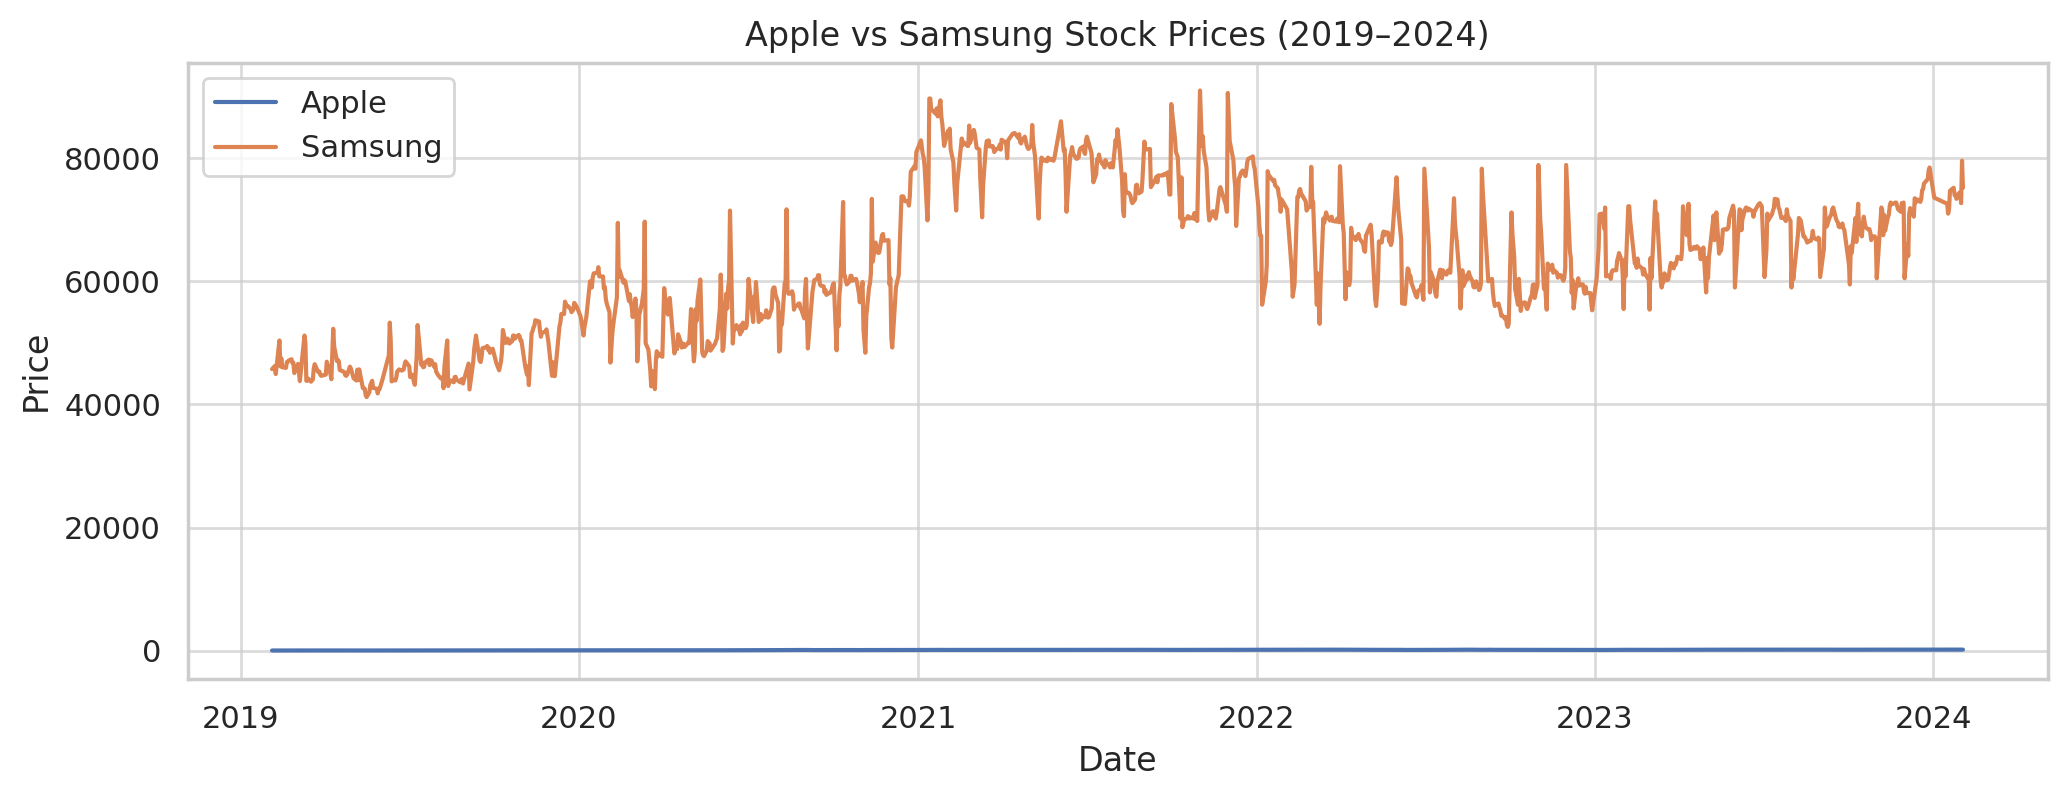

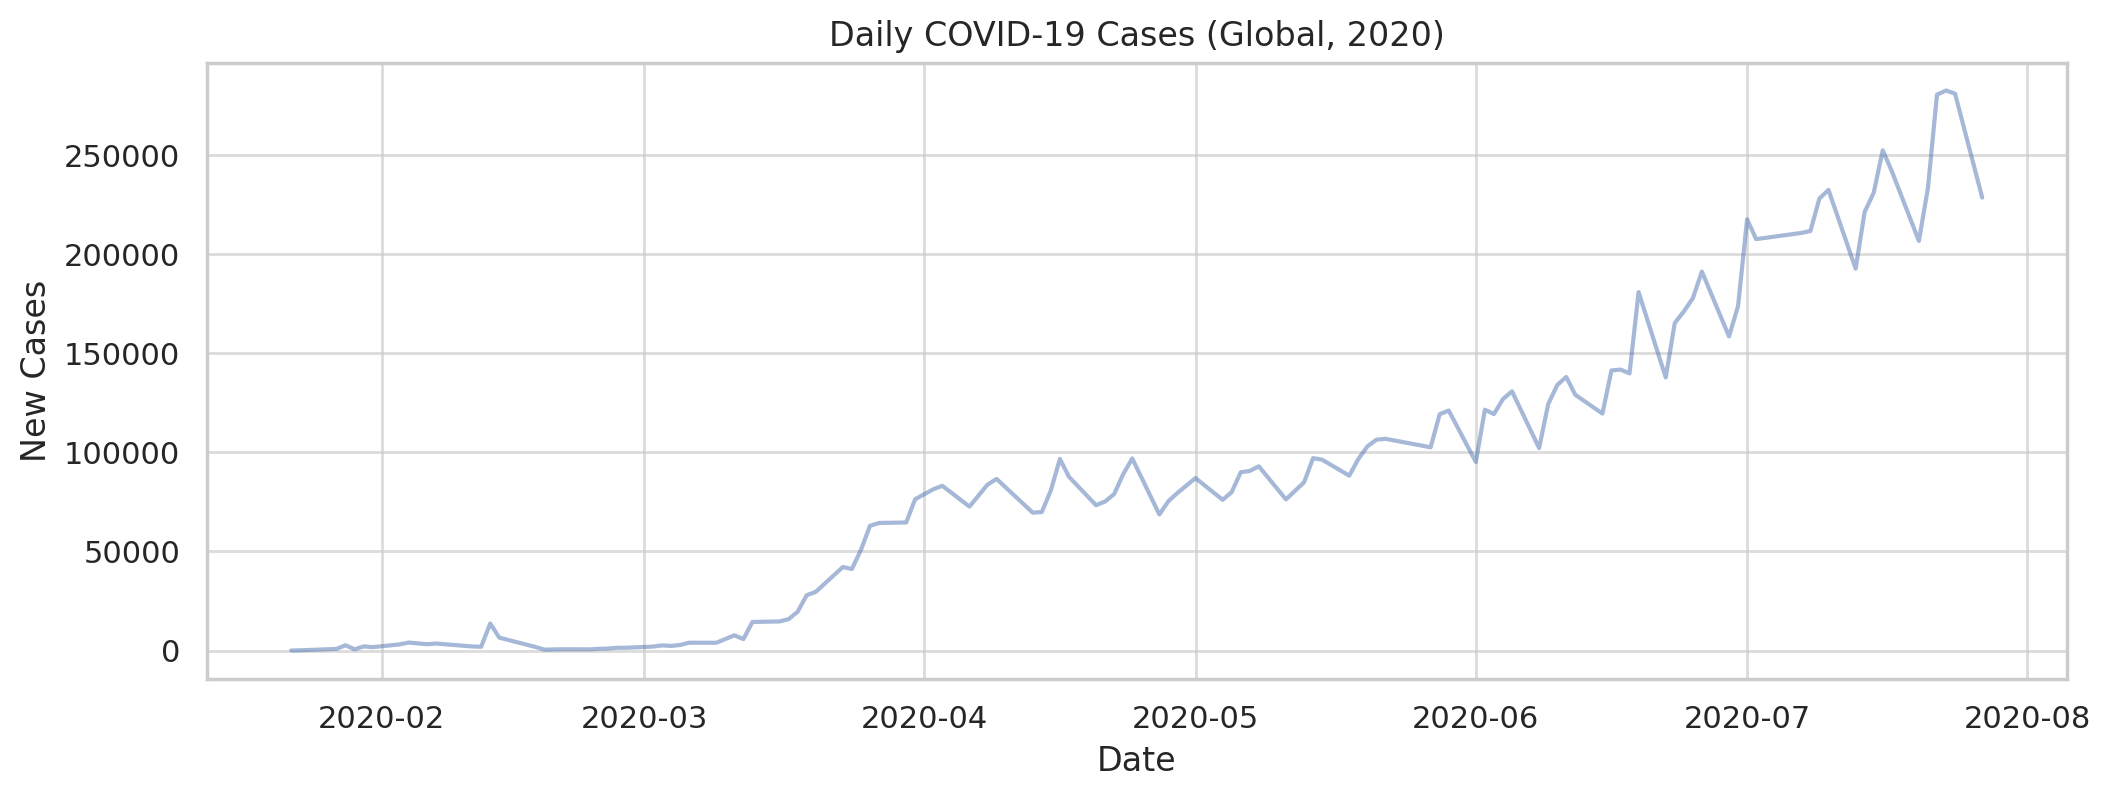

In [5]:
# Apple vs Samsung stock prices
plt.plot(df["Date"], df["Apple_Price"], label="Apple")
plt.plot(df["Date"], df["Samsung_Price"], label="Samsung")
plt.title("Apple vs Samsung Stock Prices (2019–2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# COVID-19 daily cases
covid_part = df.dropna(subset=["Covid_Cases"])
plt.plot(covid_part["Date"], covid_part["Covid_Cases"], alpha=0.5)
plt.title("Daily COVID-19 Cases (Global, 2020)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

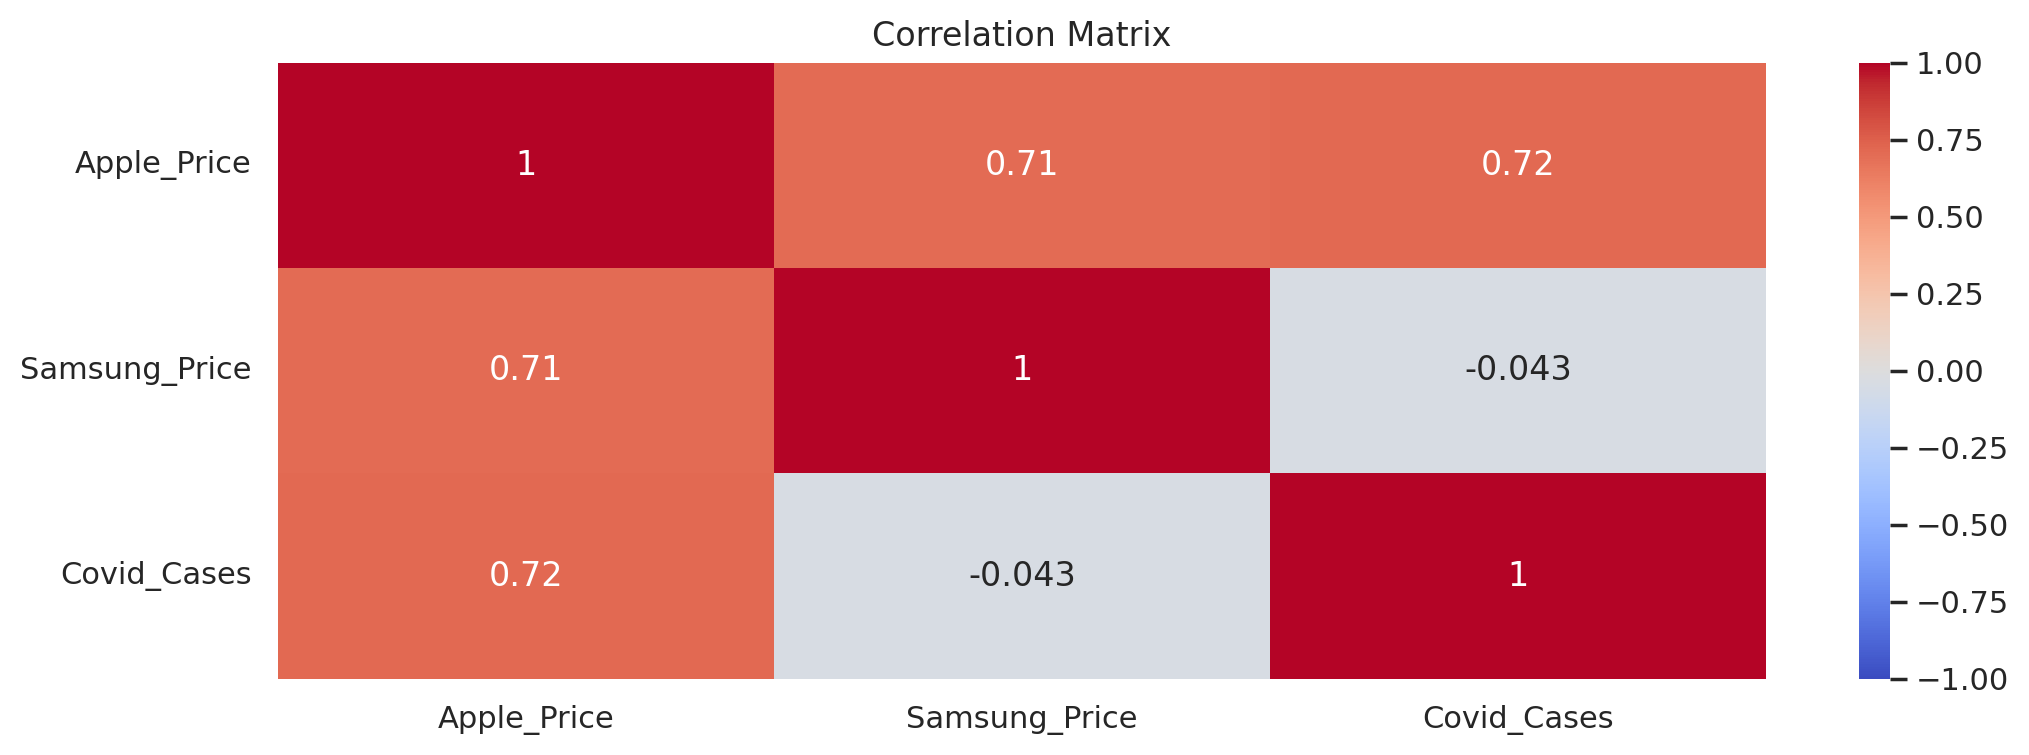

,Apple_Price,Samsung_Price,Covid_Cases
Apple_Price,1.000000,0.706391,0.717072
Samsung_Price,0.706391,1.000000,-0.043066
Covid_Cases,0.717072,-0.043066,1.000000


In [6]:
# Correlation matrix
corr_mat = df[["Apple_Price", "Samsung_Price", "Covid_Cases"]].corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

corr_mat

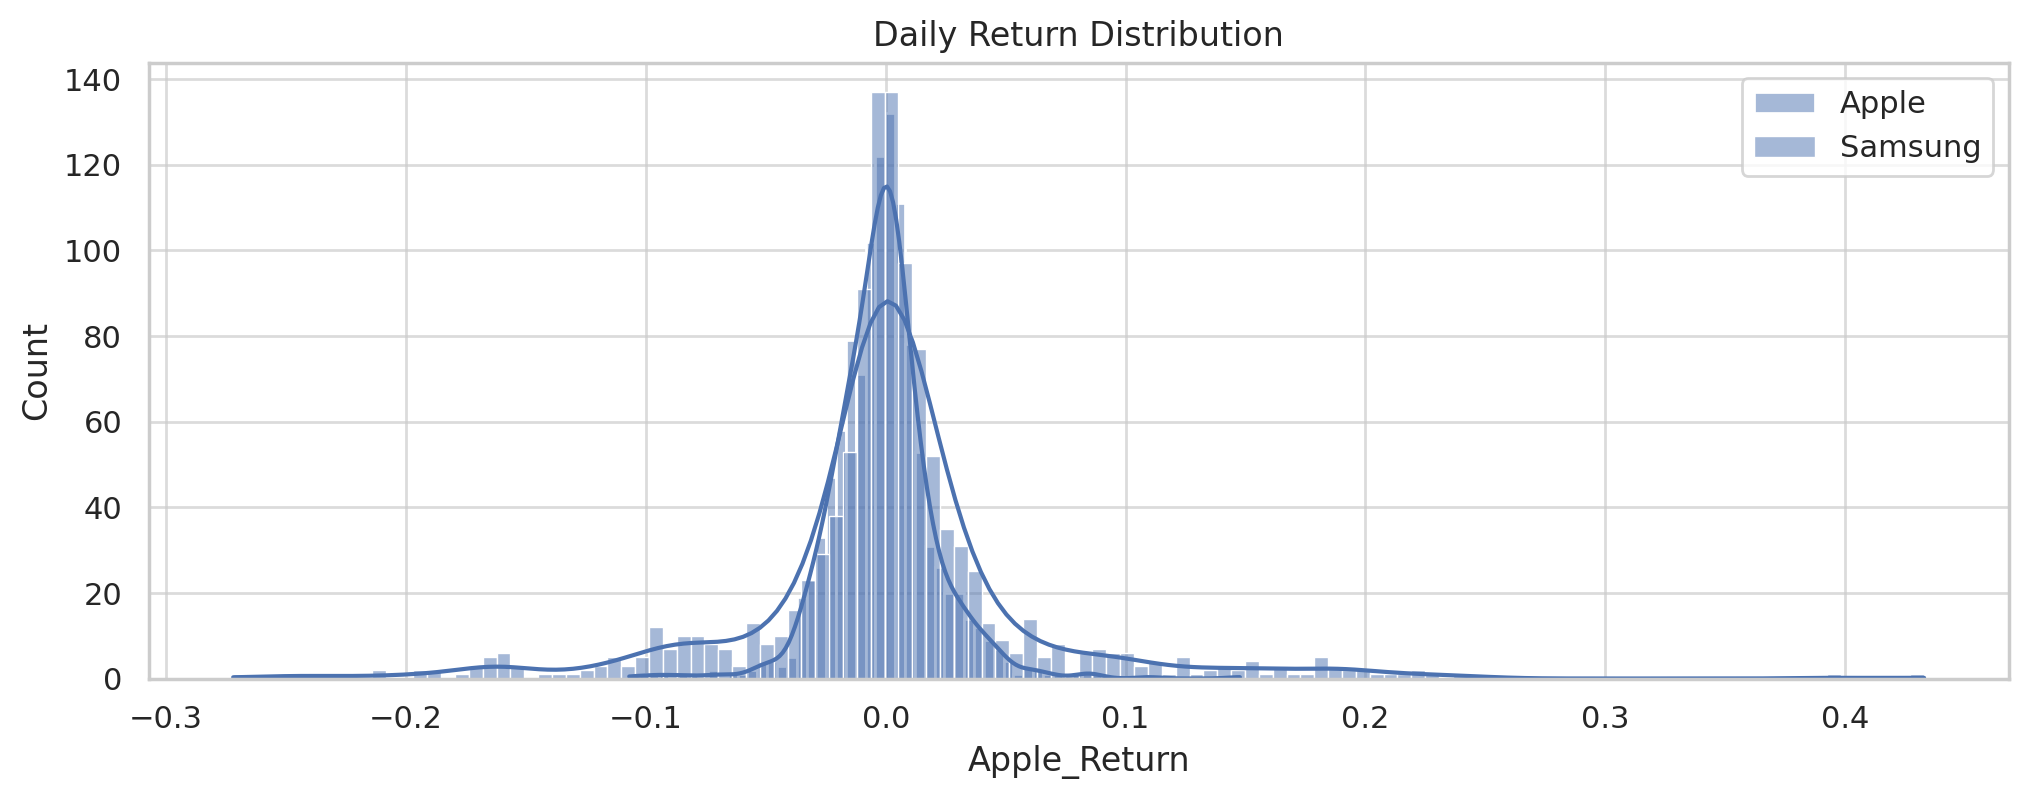

In [7]:
# Daily returns
df["Apple_Return"] = df["Apple_Price"].pct_change()
df["Samsung_Return"] = df["Samsung_Price"].pct_change()

sns.histplot(df["Apple_Return"], kde=True, label="Apple")
sns.histplot(df["Samsung_Return"], kde=True, label="Samsung")
plt.legend()
plt.title("Daily Return Distribution")
plt.show()

## 4. Hypothesis Testing

This section tests hypotheses H1–H5 using:
- Independent t-tests  
- Pearson correlations  
- Volatility (standard deviation of returns)  


In [8]:
# H1: Early COVID period growth comparison
early_period = df[df["Date"] < "2020-06-01"]

apple_growth = early_period["Apple_Return"].dropna()
samsung_growth = early_period["Samsung_Return"].dropna()

t_stat, p_val = ttest_ind(apple_growth, samsung_growth)
print("H1 Apple vs Samsung Early Growth T-test")
print("t =", t_stat, " p =", p_val)

H1 Apple vs Samsung Early Growth T-test
t = -0.753464184827472  p = 0.4514799610351188


In [9]:
# H2 & H5: Monthly average prices
df["Month"] = df["Date"].dt.to_period("M")
monthly = df.groupby("Month")[["Apple_Price", "Samsung_Price"]].mean().reset_index()

t_stat2, p_val2 = ttest_ind(monthly["Apple_Price"], monthly["Samsung_Price"])
print("Monthly Price Comparison T-test")
print("t =", t_stat2, " p =", p_val2)

Monthly Price Comparison T-test
t = -44.19740319041009  p = 4.2065876243887715e-76


In [10]:
# H3: Correlation between COVID-19 cases and stock prices
apple_corr_df = df[["Covid_Cases", "Apple_Price"]].dropna()
samsung_corr_df = df[["Covid_Cases", "Samsung_Price"]].dropna()

corr_apple, p_apple = pearsonr(apple_corr_df["Covid_Cases"], apple_corr_df["Apple_Price"])
corr_samsung, p_samsung = pearsonr(samsung_corr_df["Covid_Cases"], samsung_corr_df["Samsung_Price"])

print("COVID–Apple Price Correlation:", corr_apple, "p =", p_apple)
print("COVID–Samsung Price Correlation:", corr_samsung, "p =", p_samsung)

COVID–Apple Price Correlation: 0.7170720849930821 p = 3.2177753641023826e-20
COVID–Samsung Price Correlation: -0.043066176854007474 p = 0.6404675586884172


In [11]:
# H4: Post-2021 volatility comparison
post21 = df[df["Date"] > "2021-01-01"]

vol_apple = post21["Apple_Return"].std()
vol_samsung = post21["Samsung_Return"].std()

print("Apple Volatility (post-2021):", vol_apple)
print("Samsung Volatility (post-2021):", vol_samsung)

Apple Volatility (post-2021): 0.018359838783834414
Samsung Volatility (post-2021): 0.05785977965406582


## 5. Summary of Findings (28 November Stage)

- Apple and Samsung stock prices show a strong positive correlation.
- Apple stock prices are strongly correlated with global COVID-19 cases, 
  while Samsung shows no meaningful correlation.
- **H1 rejected**: early-pandemic growth of Apple and Samsung is not significantly different.
- **H2 rejected** and **H5 supported**: Samsung has higher prices, but Apple demonstrates more stable returns.
- **H4 accepted**: Samsung is about 3× more volatile than Apple after 2021.

This concludes the data collection, cleaning, EDA, and hypothesis testing phase.
The next milestone (02 January) will involve machine learning models for prediction and comparison.
